In [1]:
# Data exploration

In [2]:
# Setting up enviornment
import os

os.environ['TRANSFORMERS_CACHE'] = '/scratch/hf_cache'
os.environ['HF_HOME'] = '/scratch/hf_cache'

In [3]:
# Loading images from bioscan dataset
!pip install bioscan-dataset
from bioscan_dataset import BIOSCAN5M
#ds = BIOSCAN5M("./Data/5m", download=True)

Defaulting to user installation because normal site-packages is not writeable


/opt/conda/lib/python3.11/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
There was a problem when trying to write in your cache folder (/scratch/hf_cache). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.


In [4]:
# load metadata
from pyspark.sql import SparkSession

# set up SparkSession
spark = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", 7) \
    .getOrCreate()

In [5]:
# Writable directory for cache and config files
import os
cache_dir = os.path.join(os.getcwd(), "mpl_cache")

os.makedirs(cache_dir, exist_ok=True)
os.environ["MPLCONFIGDIR"] = cache_dir

In [6]:
!pip install folium

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, when, isnull, udf, lit, length, col, pandas_udf
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')
from pyspark.sql.types import ArrayType, StringType, IntegerType
import pygeohash as geohash
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import random
from PIL import Image, UnidentifiedImageError
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import shutil
from sklearn.model_selection import train_test_split
import folium

Defaulting to user installation because normal site-packages is not writeable


In [7]:
# Overview of dataset
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BIOSCAN Metadata").getOrCreate()
df = spark.read.csv('BIOSCAN_5M_Insect_Dataset_metadata.csv', header=True, inferSchema=True)
# df = spark.read.option("header", True).csv(ds.metadata_path)
df.printSchema()
df.show(5)

root
 |-- processid: string (nullable = true)
 |-- sampleid: string (nullable = true)
 |-- taxon: string (nullable = true)
 |-- phylum: string (nullable = true)
 |-- class: string (nullable = true)
 |-- order: string (nullable = true)
 |-- family: string (nullable = true)
 |-- subfamily: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- species: string (nullable = true)
 |-- dna_bin: string (nullable = true)
 |-- dna_barcode: string (nullable = true)
 |-- country: string (nullable = true)
 |-- province_state: string (nullable = true)
 |-- coord-lat: double (nullable = true)
 |-- coord-lon: double (nullable = true)
 |-- image_measurement_value: double (nullable = true)
 |-- area_fraction: double (nullable = true)
 |-- scale_factor: double (nullable = true)
 |-- inferred_ranks: integer (nullable = true)
 |-- split: string (nullable = true)
 |-- index_bioscan_1M_insect: double (nullable = true)
 |-- chunk: string (nullable = true)

+-----------+--------------+------------

In [8]:
#describe the statistic features
df.describe().show()

+-------+------------+-----------------+-------------+----------+---------+---------+--------------------+--------------------+-------------+--------------------+------------+--------------------+-------+--------------+------------------+------------------+-----------------------+-------------------+------------------+-------------------+----------+-----------------------+------------------+
|summary|   processid|         sampleid|        taxon|    phylum|    class|    order|              family|           subfamily|        genus|             species|     dna_bin|         dna_barcode|country|province_state|         coord-lat|         coord-lon|image_measurement_value|      area_fraction|      scale_factor|     inferred_ranks|     split|index_bioscan_1M_insect|             chunk|
+-------+------------+-----------------+-------------+----------+---------+---------+--------------------+--------------------+-------------+--------------------+------------+--------------------+-------+------

In [9]:
total_rows = df.count()
print(f"Total number of rows: {total_rows}")

Total number of rows: 5150850


In [10]:
# count null values in each column
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---------+--------+-----+------+-----+-----+------+---------+-------+-------+-------+-----------+-------+--------------+---------+---------+-----------------------+-------------+------------+--------------+-----+-----------------------+------+
|processid|sampleid|taxon|phylum|class|order|family|subfamily|  genus|species|dna_bin|dna_barcode|country|province_state|coord-lat|coord-lon|image_measurement_value|area_fraction|scale_factor|inferred_ranks|split|index_bioscan_1M_insect| chunk|
+---------+--------+-----+------+-----+-----+------+---------+-------+-------+-------+-----------+-------+--------------+---------+---------+-----------------------+-------------+------------+--------------+-----+-----------------------+------+
|        0|       0|    0|     0| 4013|15863|218076|  3678302|3924085|4677756|  13409|          0|      8|         92132|     1831|     1831|                  46638|            0|           0|             0|    0|                4024462|107301|
+---------+--------+

In [11]:
# Checking for each taxonomic family name
df.groupBy("family").count().orderBy("count", ascending=False).show()

+---------------+------+
|         family| count|
+---------------+------+
|  Cecidomyiidae|938928|
|   Chironomidae|586347|
|       Phoridae|546530|
|      Sciaridae|458315|
|Ceratopogonidae|323677|
|           NULL|218076|
|    Psychodidae|172974|
|    Scelionidae|110935|
|   Cicadellidae|108594|
| Dolichopodidae|104308|
| Sphaeroceridae| 66133|
|     Formicidae| 61783|
|     Braconidae| 61495|
|  Chrysomelidae| 45325|
|  Drosophilidae| 42870|
|     Diapriidae| 41349|
| Mycetophilidae| 40321|
|  Staphylinidae| 39779|
|      Hybotidae| 39317|
|    Chloropidae| 38756|
+---------------+------+
only showing top 20 rows



In [12]:
df.select('image_measurement_value','area_fraction').show(5)

+-----------------------+-------------+
|image_measurement_value|area_fraction|
+-----------------------+-------------+
|                 2353.0|       0.0117|
|                 8137.0|       0.0356|
|                28915.0|       0.0885|
|               129334.0|       0.3962|
|                66336.0|       0.2015|
+-----------------------+-------------+
only showing top 5 rows



In [13]:
# change null values in 'image_measurement_value' to 'unknown'
# and show the statistic values
from pyspark.sql.functions import when, col
df = df.fillna({'image_measurement_value': 'unknown'})
df.describe('image_measurement_value').show()

+-------+-----------------------+
|summary|image_measurement_value|
+-------+-----------------------+
|  count|                5104212|
|   mean|      26871.80608524881|
| stddev|      43926.01073004631|
|    min|                    0.0|
|    max|               935857.0|
+-------+-----------------------+



/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


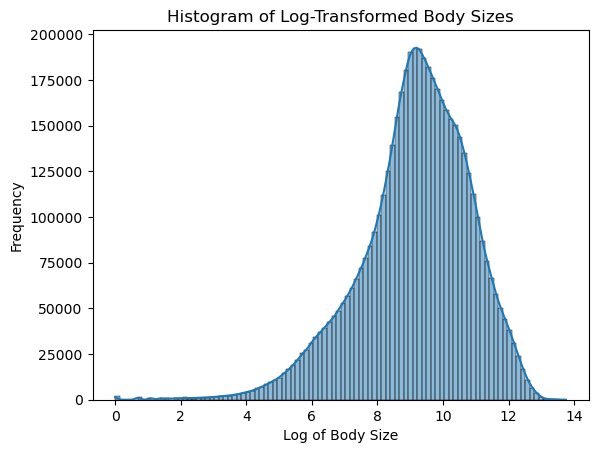

In [14]:
# plot the histogram of insects' body sizes
df_cleaned = df[df['image_measurement_value'] > 0]
pandas_df = df.select('image_measurement_value').toPandas()

# original data is so right skewed, so change to log then plot again
# pandas_df['image_measurement_value'] = pd.to_numeric(pandas_df['image_measurement_value'], errors='coerce')
pandas_df['log_image_measurement_value'] = np.log(pandas_df['image_measurement_value'])
sns.histplot(pandas_df['log_image_measurement_value'], bins=100, kde=True)
plt.title('Histogram of Log-Transformed Body Sizes')
plt.xlabel('Log of Body Size')
plt.ylabel('Frequency')
plt.show()

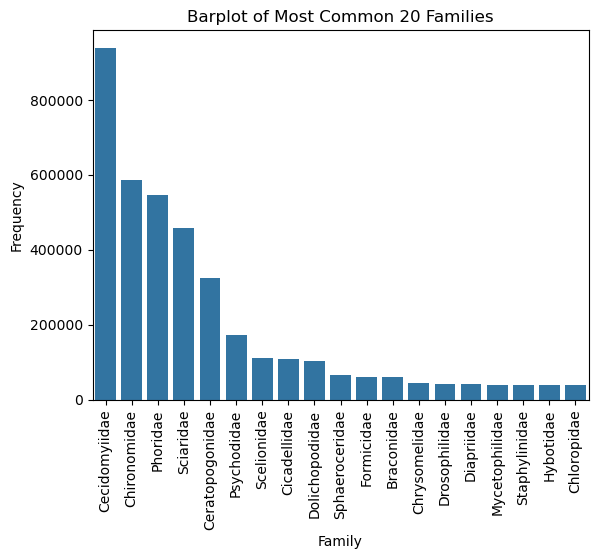

In [15]:
# plot the bar chart of the most common families
family_df = df.groupBy('family').count()
most_common_20_families = family_df.orderBy('count', ascending=False).limit(20)
pandas_family_df = most_common_20_families.toPandas()

sns.barplot(x = 'family', y = 'count', data = pandas_family_df)
plt.title('Barplot of Most Common 20 Families')
plt.xlabel('Family')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


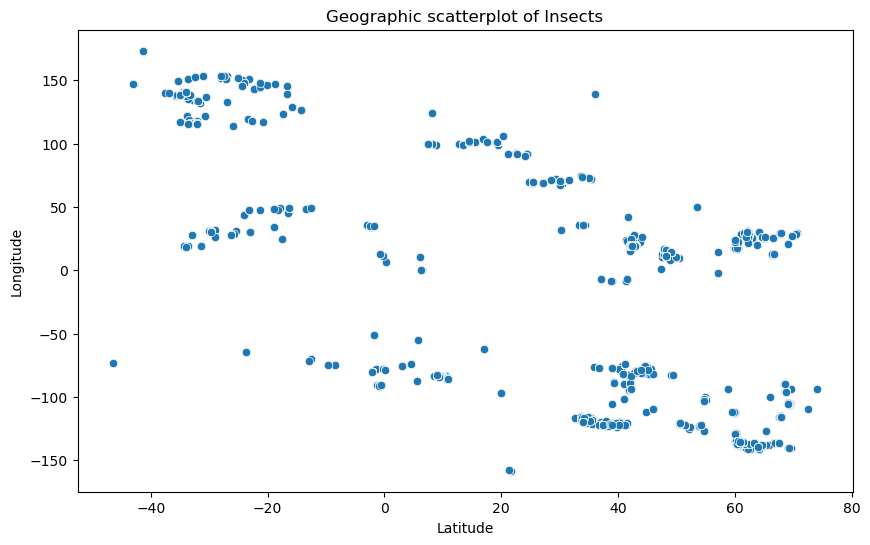

In [16]:
# Geographic scatterplot (latitude vs. longitude)

df_lat_lon_cleaned = df.filter(df['coord-lat'].isNotNull() & df['coord-lon'].isNotNull())

pandas_lat_lon_df = df_lat_lon_cleaned.select('coord-lat','coord-lon').toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'coord-lat', y = 'coord-lon', data = pandas_lat_lon_df)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Geographic scatterplot of Insects')
plt.show()

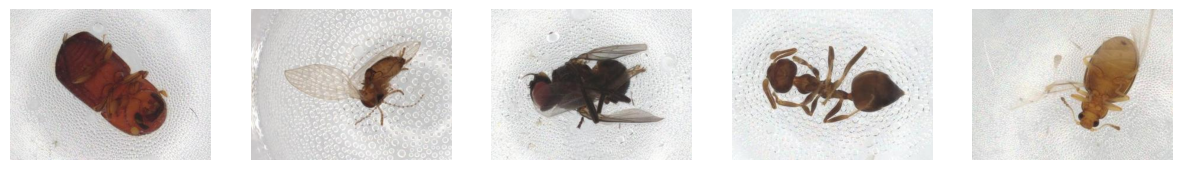

In [17]:
# Testing to see if images are contained within cropped image folders

spark = SparkSession.builder.appName("ImageLoader").getOrCreate()

df_image = spark.read.format("image").option("dropInvalid", True).load('Data/5m/bioscan5m/images/cropped_256/train/0')
image_paths = df_image.select("image").rdd.map(lambda r: r[0]['origin'][7:]).collect()

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, image_path in enumerate(image_paths[:5]):
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

In [18]:
# Verifying quality of images by sampling 50 images per class, and checking for any corrupted or wrong-sized images
import os
BASE_DIR         = "Data/5m/bioscan5m"
IMAGE_TRAIN_DIR  = os.path.join(BASE_DIR, "images", "cropped_256", "train")


MAX_PER_CLASS    = 50
expected_size    = (256, 256)


classes = sorted(os.listdir(IMAGE_TRAIN_DIR))

sampled_paths = []
for cls in classes:
    cls_dir = os.path.join(IMAGE_TRAIN_DIR, cls)
    all_imgs = os.listdir(cls_dir)
    
    k = min(len(all_imgs), MAX_PER_CLASS)
    picks = random.sample(all_imgs, k)
    sampled_paths += [os.path.join(cls_dir, f) for f in picks]

print(f" Sampling {len(sampled_paths)} images "
      f"({MAX_PER_CLASS} per each of {len(classes)} classes)")

valid, corrupt, wrong_size = [], [], []
for fpath in sampled_paths:
    try:
        with Image.open(fpath) as img:
            img.verify()
        with Image.open(fpath) as img2:
            if img2.size != expected_size:
                wrong_size.append((fpath, img2.size))
        valid.append(fpath)
    except (UnidentifiedImageError, OSError):
        corrupt.append(fpath)


print(f" Valid in sample:        {len(valid)}")
print(f" Corrupt in sample:      {len(corrupt)}")
print(f" Wrong-size in sample: {len(wrong_size)}")
if wrong_size:
    print("Example bad size:", wrong_size[0])

 Sampling 800 images (50 per each of 16 classes)
 Valid in sample:        800
 Corrupt in sample:      0
 Wrong-size in sample: 800
Example bad size: ('Data/5m/bioscan5m/images/cropped_256/train/0/KUGLA008-22.jpg', (341, 256))


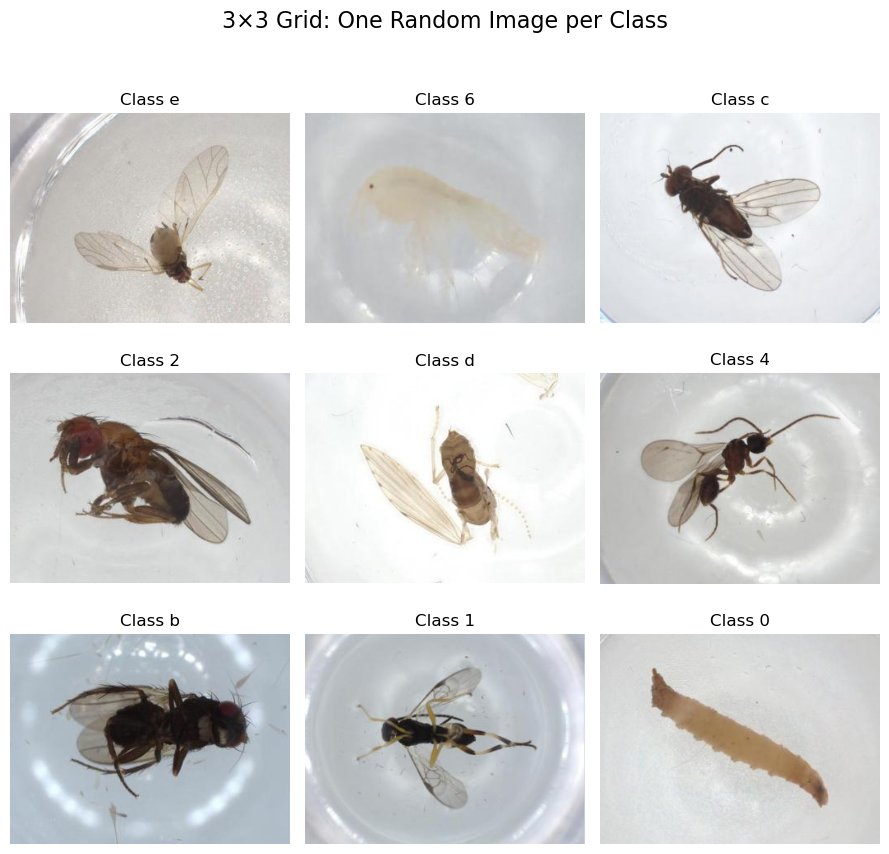

In [19]:
# 3x3 Grid sample images from different classes

sampled_classes = random.sample(classes, 9)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for idx, cls in enumerate(sampled_classes):
    cls_dir = os.path.join(IMAGE_TRAIN_DIR, cls)
    img_name = random.choice(os.listdir(cls_dir))
    img_path = os.path.join(cls_dir, img_name)
    img = Image.open(img_path)
    
    ax = axes[idx // 3, idx % 3]
    ax.imshow(img)
    ax.set_title(f"Class {cls}")
    ax.axis("off")

plt.suptitle("3×3 Grid: One Random Image per Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Columns in metadata: ['processid', 'sampleid', 'taxon', 'phylum', 'class', 'order', 'family', 'subfamily', 'genus', 'species', 'dna_bin', 'dna_barcode', 'country', 'province_state', 'coord-lat', 'coord-lon', 'image_measurement_value', 'area_fraction', 'scale_factor', 'inferred_ranks', 'split', 'index_bioscan_1M_insect', 'chunk']
 Distinct Orders: 55


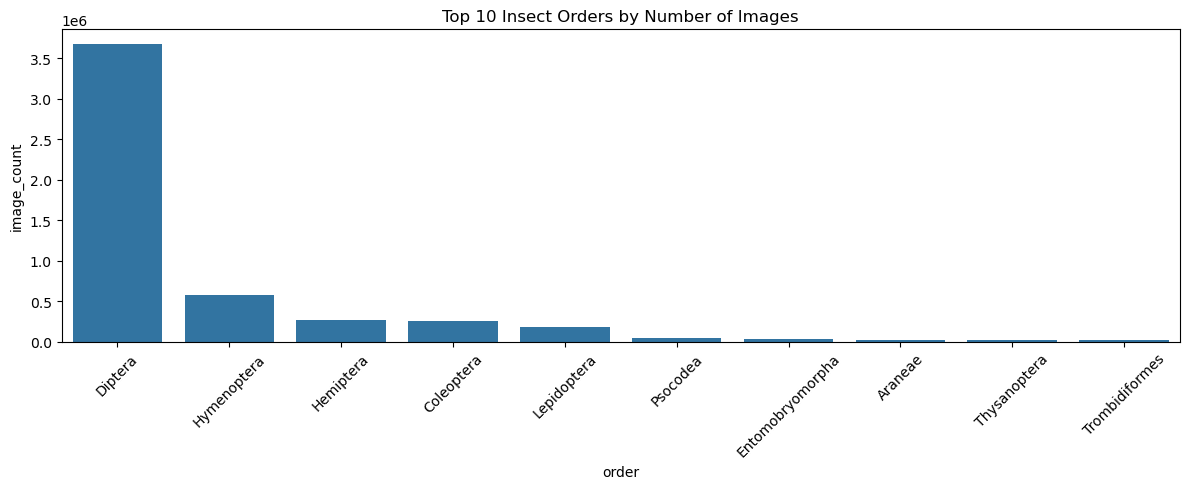

In [ ]:
# Checking columns and ranking insect "order" for the top 10 orders by image counts (Diptera group has the most image samples) 

df = pd.read_csv("Data/5m/bioscan5m/metadata/csv/BIOSCAN_5M_Insect_Dataset_metadata.csv")
print("Columns in metadata:", df.columns.tolist())

for rank in ['order', 'family', 'genus', 'species']:
    if rank in df.columns:
        unique_count = df[rank].nunique()
        print(f" Distinct {rank.capitalize()}s: {unique_count}")
print()

order_counts = df['order'].value_counts().reset_index()
order_counts.columns = ['order', 'image_count']
print("Top 10 Orders by Image Count:")
print(order_counts.head(10).to_string(index=False))

plt.figure(figsize=(12,5))
sns.barplot(
    data=order_counts.head(10),
    x='order', y='image_count')
plt.xticks(rotation=45)
plt.title("Top 10 Insect Orders by Number of Images")
plt.tight_layout()
plt.show()

In [21]:
# Data Preprocessing

In [22]:
# for few missing values, use mode to fill in
df = spark.read.csv('BIOSCAN_5M_Insect_Dataset_metadata.csv', header=True, inferSchema=True)
df = df.fillna({
    'country': df.select('country').groupBy().agg({'country':'max'}).collect()[0][0],
    'coord-lat': df.select('coord-lat').groupBy().agg({'coord-lat':'max'}).collect()[0][0],
    'coord-lon': df.select('coord-lon').groupBy().agg({'coord-lon':'max'}).collect()[0][0],
})

# for many missing values, drop some unimportant columns
df = df.drop('subfamily', 'genus', 'species', 'index_bioscan_1M_insect', 'chunk')

# for some important columns, use mode or median to fill in
df = df.fillna({
    'family': df.select('family').groupBy().agg({'family': 'max'}).collect()[0][0],  
    'image_measurement_value': df.approxQuantile('image_measurement_value', [0.5], 0)[0]  
})

# for some important columns, drop some lines
df_cleaned = df.filter(df['coord-lat'].isNotNull() & df['coord-lon'].isNotNull())

In [23]:
# cleaning DNA values

In [24]:
df_cleaned.select('dna_barcode').show(5)

+--------------------+
|         dna_barcode|
+--------------------+
|CTTTATACTTTATTTTT...|
|TCTTTATTTTATTTTTG...|
|CTTTATATTTTATTTTT...|
|TTTATATTTTATTTTTG...|
|TTATATTTCTTATTTGG...|
+--------------------+
only showing top 5 rows



In [25]:
# use k_mer and one_hot_encode
def generate_kmers(sequence, k=6):
    return [sequence[i:i+k] for i in range(0, len(sequence), k)]

generate_kmers_udf = udf(generate_kmers, ArrayType(StringType()))

df_cleaned_kmer = df_cleaned.withColumn('k_mer', generate_kmers_udf(df_cleaned['dna_barcode'], lit(6)))

In [26]:
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
    return [encoding.get(nucleotide, [0, 0, 0, 0]) for nucleotide in sequence]

one_hot_encode_udf = udf(one_hot_encode, ArrayType(ArrayType(IntegerType())))
df_cleaned_DNA = df_cleaned_kmer.withColumn('one_hot_encoded', one_hot_encode_udf(df_cleaned_kmer['k_mer']))

In [27]:
print(df_cleaned_DNA.columns)

['processid', 'sampleid', 'taxon', 'phylum', 'class', 'order', 'family', 'dna_bin', 'dna_barcode', 'country', 'province_state', 'coord-lat', 'coord-lon', 'image_measurement_value', 'area_fraction', 'scale_factor', 'inferred_ranks', 'split', 'k_mer', 'one_hot_encoded']


In [28]:
# filter some poor-quality values

In [29]:
df_cleaned_DNA = df_cleaned_DNA.withColumn('sequence_length', length(df_cleaned_DNA['dna_barcode']))

df_cleaned_DNA = df_cleaned_DNA.filter(df_cleaned_DNA['sequence_length']>100)
df_cleaned_DNA = df_cleaned_DNA.filter(~df_cleaned_DNA['dna_barcode'].contains('N'))

In [30]:
# standardize geographic data

In [31]:
df_cleaned_DNA_geography = df_cleaned_DNA.filter( df_cleaned_DNA['coord-lat']
                                                 .isNotNull() &  df_cleaned_DNA['coord-lon']
                                                 .isNotNull())

In [32]:
# convert lon&lat to float
df_cleaned_DNA_geography = df_cleaned_DNA_geography.withColumn('coord-lat', col('coord-lat').cast('float'))
df_cleaned_DNA_geography = df_cleaned_DNA_geography.withColumn('coord-lon', col('coord-lon').cast('float'))


In [33]:
# handling some invalid geographic values
df_cleaned_DNA_geography = df_cleaned_DNA_geography.filter(
    (df_cleaned_DNA_geography['coord-lat'] >= -90) & (df_cleaned_DNA_geography['coord-lat'] <= 90) & 
    (df_cleaned_DNA_geography['coord-lon'] >= -180) & (df_cleaned_DNA_geography['coord-lon'] <= 180)
)


In [34]:
# create a pandas_udf，encode lon&lat using geohash
@pandas_udf(StringType())
def geohash_udf(lat_series, lon_series):
    return lat_series.combine(lon_series, lambda lat, lon: geohash.encode(lat, lon, precision=5))

# using geohash_udf to get geohash
df_cleaned_DNA_geography = df_cleaned_DNA_geography.withColumn('geohash', geohash_udf(df_cleaned_DNA_geography['coord-lat'], df_cleaned_DNA_geography['coord-lon']))
df_cleaned_DNA_geography.show(5)


+-----------+--------------+--------------------+----------+-------+-----------+-------------+------------+--------------------+----------+--------------+---------+---------+-----------------------+-------------+------------+--------------+--------+--------------------+--------------------+---------------+-------+
|  processid|      sampleid|               taxon|    phylum|  class|      order|       family|     dna_bin|         dna_barcode|   country|province_state|coord-lat|coord-lon|image_measurement_value|area_fraction|scale_factor|inferred_ranks|   split|               k_mer|     one_hot_encoded|sequence_length|geohash|
+-----------+--------------+--------------------+----------+-------+-----------+-------------+------------+--------------------+----------+--------------+---------+---------+-----------------------+-------------+------------+--------------+--------+--------------------+--------------------+---------------+-------+
|PLGBW211-19|BIOUG51398-C03|            Metopina|Art

In [35]:
# KMeans clustering

In [36]:
assembler = VectorAssembler(inputCols = ['coord-lat','coord-lon'], outputCol = 'features')
kmeans = KMeans (k = 5, seed = 42, featuresCol = 'features', predictionCol = 'cluster')

In [37]:
pipeline = Pipeline(stages = [assembler, kmeans])
model = pipeline.fit(df_cleaned_DNA_geography)
predictions = model.transform(df_cleaned_DNA_geography)
predictions = predictions.select("coord-lat", "coord-lon", "cluster")

predictions.select('coord-lat','coord-lon','cluster').show(5)

+---------+---------+-------+
|coord-lat|coord-lon|cluster|
+---------+---------+-------+
|   10.761|  -85.335|      0|
|   10.761|  -85.335|      0|
|   10.761|  -85.335|      0|
|   10.761|  -85.335|      0|
|   10.761|  -85.335|      0|
+---------+---------+-------+
only showing top 5 rows



In [42]:
# Adjust image sizes by 256 x 256

# from tqdm import tqdm  

# RAW_DIR       = "Data/5m/bioscan5m/images/cropped_256/train"
# RESIZED_ROOT  = "Data/5m/bioscan5m/images_resized/256x256/train"
# TARGET_SIZE   = (256, 256)

# for class_id in os.listdir(RAW_DIR):
#     src_cls_dir = os.path.join(RAW_DIR, class_id)
#     dst_cls_dir = os.path.join(RESIZED_ROOT, class_id)
#     os.makedirs(dst_cls_dir, exist_ok=True)
    
#     files = [f for f in os.listdir(src_cls_dir) 
#              if f.lower().endswith(('.png','.jpg','.jpeg'))]
    
#     for fname in tqdm(files, desc=f"Resizing {class_id}", unit="img"):
#         src_path = os.path.join(src_cls_dir, fname)
#         dst_path = os.path.join(dst_cls_dir, fname)
        
#         try:
#             with Image.open(src_path) as img:
#                 img_resized = img.resize(TARGET_SIZE, Image.Resampling.BILINEAR)
#                 img_resized.save(dst_path)
#         except Exception as e:
#             print(f"  Skipped {src_path}: {e}")


import os
from tqdm import tqdm
from PIL import Image

RAW_DIR = "Data/5m/bioscan5m/images/cropped_256/train"
RESIZED_ROOT = "Data/5m/bioscan5m/images_resized/256x256/train"
TARGET_SIZE = (256, 256)

folders = os.listdir(RAW_DIR)
folders_to_process = ['1']

for class_id in folders_to_process:
    src_cls_dir = os.path.join(RAW_DIR, class_id)
    dst_cls_dir = os.path.join(RESIZED_ROOT, class_id)
    os.makedirs(dst_cls_dir, exist_ok=True)

    files = [f for f in os.listdir(src_cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for fname in tqdm(files, desc=f"Resizing {class_id}", unit="img"):
        src_path = os.path.join(src_cls_dir, fname)
        dst_path = os.path.join(dst_cls_dir, fname)

        # Skip resizing if the file already exists
        if os.path.exists(dst_path):
            continue

        try:
            with Image.open(src_path) as img:
                img_resized = img.resize(TARGET_SIZE, Image.Resampling.BILINEAR)
                img_resized.save(dst_path)
        except Exception as e:
            print(f"Skipped {src_path}: {e}")


Resizing 1: 100%|██████████| 18128/18128 [49:51<00:00,  6.06img/s]   


In [44]:
# Normalize pixel values to [0,1]

RESIZED_DIR = "Data/5m/bioscan5m/images_resized/256x256/train"
NORMALIZED_ROOT = "Data/5m/bioscan5m/images_normalized/256x256/train"

# for cls in os.listdir(RESIZED_DIR):
#     os.makedirs(os.path.join(NORMALIZED_ROOT, cls), exist_ok=True)

# for cls in os.listdir(RESIZED_DIR):
#     src_cls = os.path.join(RESIZED_DIR, cls)
#     dst_cls = os.path.join(NORMALIZED_ROOT, cls)
#     for fname in os.listdir(src_cls):
#         src_path = os.path.join(src_cls, fname)
#         dst_path = os.path.join(dst_cls, fname)
        
#         img = Image.open(src_path)
#         arr = np.asarray(img, dtype=np.float32) / 255.0
#         np.save(dst_path.replace('.jpg', '.npy'), arr)

for cls in folders_to_process:
    os.makedirs(os.path.join(NORMALIZED_ROOT, cls), exist_ok=True)
    src_cls = os.path.join(RESIZED_DIR, cls)
    dst_cls = os.path.join(NORMALIZED_ROOT, cls)

    for fname in os.listdir(src_cls):
        src_path = os.path.join(src_cls, fname)
        dst_path = os.path.join(dst_cls, fname)

        # Open image and normalize pixel values
        img = Image.open(src_path)
        arr = np.asarray(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
        np.save(dst_path.replace('.jpg', '.npy'), arr)  # Save as .npy

print("Normalization completed for folder '1'.")

Normalization completed for folder '1'.


In [45]:
# Applying data augmentation

# Random rotation
augmentations = T.Compose([
    T.RandomRotation(degrees=30),



# Random horizontal and vertical flips
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),

# Convert to tensor & normalize to [0,1]
    T.ToTensor(),
])


train_dataset = ImageFolder(
    root="Data/5m/bioscan5m/images_resized/256x256/train",
    transform=augmentations
)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True
)

batch_imgs, batch_labels = next(iter(train_loader))
print("Batch shape:", batch_imgs.shape)

Batch shape: torch.Size([32, 3, 256, 256])


In [ ]:
# Splitting dataset into train, validation, test directories to preserve class balance

# Train, Val, Test proportion: 0.7, 0.15, 0.15
RAW_DIR      = "Data/5m/bioscan5m/images_resized/256x256/train" 
OUTPUT_ROOT  = "Data/5m/bioscan5m/images_split"
RATIOS       = (0.7, 0.15, 0.15) 
SEED         = 42

splits = ['train', 'val', 'test']
for sp in splits:
    for cls in os.listdir(RAW_DIR):
        os.makedirs(os.path.join(OUTPUT_ROOT, sp, cls), exist_ok=True)

for cls in os.listdir(RAW_DIR):
    cls_src = os.path.join(RAW_DIR, cls)
    imgs    = [f for f in os.listdir(cls_src) if f.lower().endswith(('.png','.jpg','.jpeg'))]


    train_imgs, temp_imgs = train_test_split(
        imgs,
        train_size=RATIOS[0],
        random_state=SEED,
        shuffle=True
    )

    val_ratio = RATIOS[1] / (RATIOS[1] + RATIOS[2])
    val_imgs, test_imgs = train_test_split(
        temp_imgs,
        train_size=val_ratio,
        random_state=SEED,
        shuffle=True
    )

    for fname in train_imgs:
        shutil.copy(
            os.path.join(cls_src, fname),
            os.path.join(OUTPUT_ROOT, 'train', cls, fname)
        )
    for fname in val_imgs:
        shutil.copy(
            os.path.join(cls_src, fname),
            os.path.join(OUTPUT_ROOT, 'val', cls, fname)
        )
    for fname in test_imgs:
        shutil.copy(
            os.path.join(cls_src, fname),
            os.path.join(OUTPUT_ROOT, 'test', cls, fname)
        )

print("Dataset split complete:")
print(f"   Train → {RATIOS[0]*100:.0f}%")
print(f"   Val   → {RATIOS[1]*100:.0f}%")
print(f"   Test  → {RATIOS[2]*100:.0f}%")

In [47]:
# Visualisation and reporting

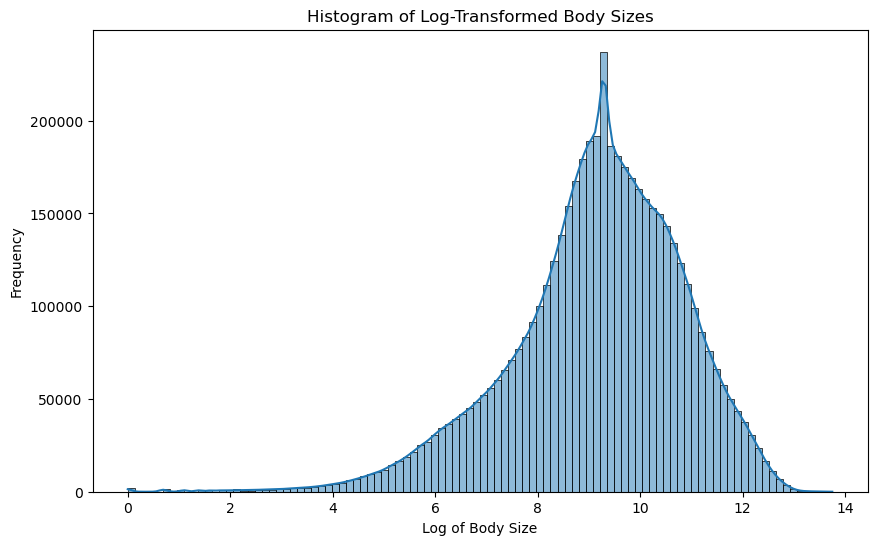

In [49]:
# After cleaning the data, plot again
# plot histogram of insects' size
plt.figure(figsize=(10, 6))
size_df = df_cleaned_DNA_geography[df_cleaned_DNA_geography['image_measurement_value'] > 0]
pandas_size_df = size_df.select('image_measurement_value').toPandas()

pandas_size_df['log_image_measurement_value'] = np.log(pandas_size_df['image_measurement_value'])
sns.histplot(pandas_size_df['log_image_measurement_value'], bins=100, kde=True)
plt.title('Histogram of Log-Transformed Body Sizes')
plt.xlabel('Log of Body Size')
plt.ylabel('Frequency')
plt.show()

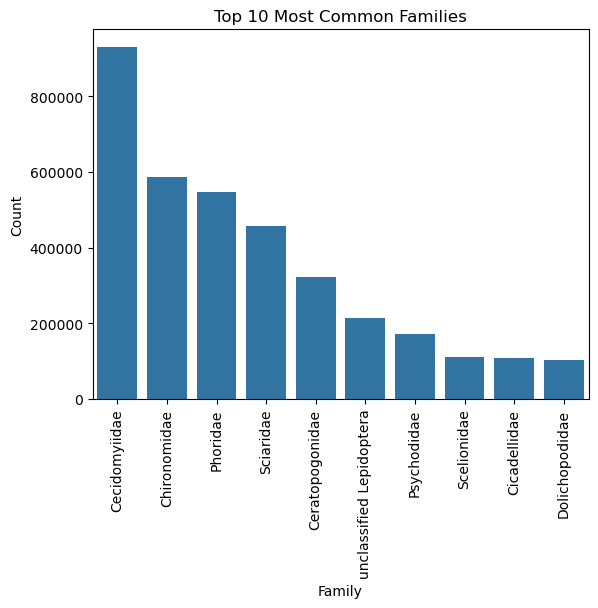

In [50]:
# plot bar chart of the most common families
family_counts = df_cleaned_DNA_geography.groupBy('family').count()

most_common_10_families = family_counts.orderBy('count', ascending=False).limit(10)
pandas_family_df_clean = most_common_10_families.toPandas()

sns.barplot(x='family', y='count', data = pandas_family_df_clean)
plt.title('Top 10 Most Common Families')
plt.xlabel('Family')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


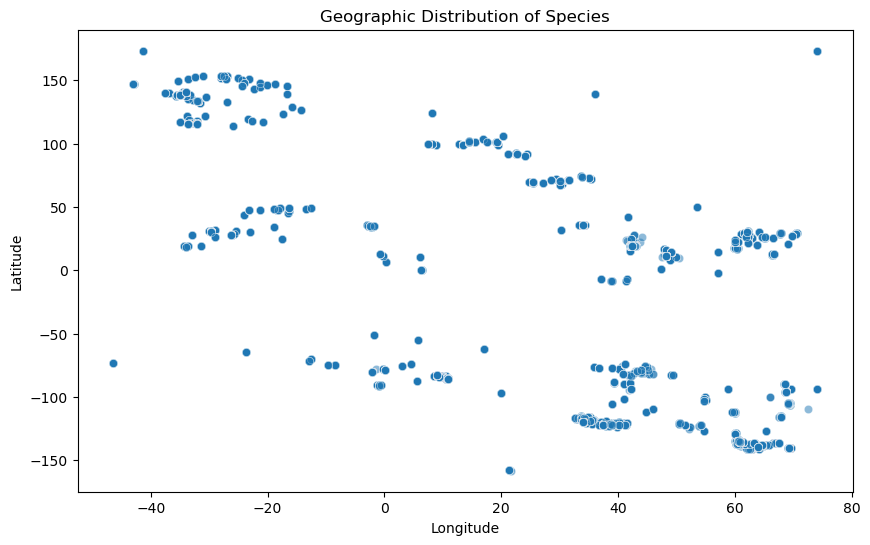

In [51]:
# Geographic scatterplot (latitude vs. longitude)

pandas_lat_lon_df_cleaned = df_cleaned_DNA_geography.select('coord-lat','coord-lon').toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'coord-lat', y = 'coord-lon', data = pandas_lat_lon_df_cleaned, alpha=0.5)
plt.title('Geographic Distribution of Species')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
# save the cleaned dataset to parquet file
# df_cleaned_DNA_geography.write.parquet("hzhao16/clean_metadata.parquet")